In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Import external dependencies

In [2]:
import argparse
import time
import math
import os
import itertools

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
# import devastator.blur as blur

## Import Blur modules

In [3]:
from blur import init_config_run, Config, Trainer, ScheduledOptimizer
from blur import Blur, DecoderXL, AdaptiveInput, AdaptiveLogSoftmaxWithLoss, DecoderFT
from blur.processing import get_lm_corpus

## Define model and training configuration

In [6]:
###############################################################################
# Define config paths
###############################################################################

config_dir = os.path.join('configs', 'xl')
config_run_path = os.path.join(config_dir, 'config_run.json')
config_encoder_path = os.path.join(config_dir, 'config_encoder.json')
config_decoder_path = os.path.join(config_dir, 'config_decoder.json')

###############################################################################
# Load config files
###############################################################################


config_model = Config(**{"tgt_len": 200, "mem_len": 150, "ext_len": 0})
config_run = init_config_run(config_run=Config.from_json(config_run_path), config_model=config_model)
config_encoder = Config.from_json(config_encoder_path)
config_decoder = Config.from_json(config_decoder_path)

## Set parameters for sandbox testing

In [7]:
device = 'cpu'
config_run.multi_gpu = False
config_run.max_step = 100

## Load data and set vocabulary length

## Build model

In [10]:
config_decoder.nft = 0
config_decoder.nxl = 16
config_decoder.ft_first = False

###############################################################################
# Build the model
###############################################################################

corpus = get_lm_corpus(config_run.data, config_run.dataset)
config_encoder.n_classes = len(corpus.vocab)

model = Blur(
    **config_model.parameters(),
    encoder = AdaptiveInput(**config_encoder.parameters()),
    decoder = DecoderFT(**config_decoder.parameters()),
    lm_loss = AdaptiveLogSoftmaxWithLoss(**config_encoder.parameters()),
)
trainer = Trainer(config_run = config_run, device = device)

pass;


Loading cached dataset...


In [11]:
# ###############################################################################
# # Build the model
# ###############################################################################

# corpus = get_lm_corpus(config_run.data, config_run.dataset)
# config_encoder.n_classes = len(corpus.vocab)

# model = Blur(
#     tgt_len = 150, mem_len = 150, ext_len = 0,
#     encoder = AdaptiveInput(**config_encoder.parameters()),
#     decoder = DecoderXL(**config_decoder.parameters()),
#     lm_loss = AdaptiveLogSoftmaxWithLoss(**config_encoder.parameters()),
# )
# trainer = Trainer(config_run = config_run, device = device)

# pass;


## Load some example data

In [12]:
from blur.training import StreamDataset, StreamCollator

In [13]:
train_set = StreamDataset(
    data=corpus.train, tgt_len=model.tgt_len, batch_size=config_run.batch_size)
train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=config_run.batch_size, shuffle=False,
        num_workers=0, pin_memory=True, sampler=None, collate_fn=StreamCollator())

In [14]:
detokenize_fn = np.vectorize(lambda x: corpus.vocab.idx2sym[x])

iterdata = {}
mems = tuple()

for batch, (data, target) in enumerate(train_loader):
    iterdata[batch] = (data, target, mems)
    
#     ret = model(data, target, *mems)
#     loss, mems = ret[0], ret[1:]
#     loss = loss.float().mean().type_as(loss)
    
    if batch>2:
        break

## Inspect example data

In [15]:
iterdata[0][0].shape

torch.Size([8, 200])

In [16]:
detokenize_fn(iterdata[0][1][0,:])[:50]
# detokenize_fn(iterdata[0][1][1,:])[:50]

array(['=', 'Valkyria', 'Chronicles', 'III', '=', '<eos>', '<eos>',
       'Senjō', 'no', 'Valkyria', '3', ':', '<unk>', 'Chronicles', '(',
       'Japanese', ':', '戦場のヴァルキュリア3', ',', 'lit', '.', 'Valkyria', 'of',
       'the', 'Battlefield', '3', ')', ',', 'commonly', 'referred', 'to',
       'as', 'Valkyria', 'Chronicles', 'III', 'outside', 'Japan', ',',
       'is', 'a', 'tactical', 'role', '@-@', 'playing', 'video', 'game',
       'developed', 'by', 'Sega', 'and'], dtype='<U12')

## Run data through model

In [17]:
output = model(*iterdata[0])
{k:v.shape if hasattr(v, 'shape') else len(v) for k,v in output.items()}

torch.Size([8, 200])
torch.Size([200, 8])
torch.Size([200, 8, 410])
torch.Size([200, 8, 410])


{'output': torch.Size([200, 8, 410]), 'mems': 17, 'loss': torch.Size([200, 8])}

In [18]:
output['mems']

[tensor([[[ 0.0150,  0.0000,  0.0284,  ...,  0.0000, -0.0341,  0.0149],
          [ 0.0194, -0.0133, -0.0160,  ...,  0.0117,  0.0027, -0.0213],
          [-0.0140, -0.0410,  0.0112,  ...,  0.0114,  0.0194, -0.0054],
          ...,
          [ 0.0023, -0.0006, -0.0037,  ...,  0.0079,  0.0000,  0.0218],
          [-0.0010, -0.0000, -0.0010,  ...,  0.0070, -0.0488, -0.0059],
          [ 0.0328, -0.0188,  0.0044,  ..., -0.0039,  0.0178, -0.0305]],
 
         [[-0.0018, -0.0000,  0.0000,  ..., -0.0164, -0.0126,  0.0000],
          [-0.0000,  0.0120,  0.0275,  ...,  0.0021, -0.0108,  0.0319],
          [-0.0140, -0.0410,  0.0112,  ...,  0.0114,  0.0194, -0.0054],
          ...,
          [-0.0463, -0.0053, -0.0033,  ..., -0.0109,  0.0057,  0.0138],
          [-0.0145,  0.0243,  0.0408,  ...,  0.0137, -0.0023,  0.0006],
          [-0.0052, -0.0222, -0.0093,  ..., -0.0028,  0.0006, -0.0111]],
 
         [[ 0.0478,  0.0110, -0.0000,  ...,  0.0099, -0.0087, -0.0047],
          [ 0.0092,  0.0338,

In [19]:
from blur.modeling.decoders.decoderfb import *

In [74]:

    
from blur.modeling.initializers import weights_init



In [75]:
config_model = Config(**{"tgt_len": 500, "mem_len": 100, "ext_len": 0})
config_run = init_config_run(config_run=Config.from_json(config_run_path), config_model=config_model)
config_encoder = Config.from_json(config_encoder_path)
config_decoder = Config.from_json(config_decoder_path)

In [76]:

###############################################################################
# Build the model
###############################################################################

corpus = get_lm_corpus(config_run.data, config_run.dataset)
config_encoder.n_classes = len(corpus.vocab)

model_fb = BlurFb(
    **config_model.parameters(),
    encoder = AdaptiveInput(**config_encoder.parameters()),
    decoder = DecoderFb(**config_decoder.parameters()),
    lm_loss = AdaptiveLogSoftmaxWithLoss(**config_encoder.parameters()),
)
trainer = Trainer(config_run = config_run, device = device)

pass;


Loading cached dataset...


In [77]:
output_fb = model_fb(*iterdata[0], return_memory=True)
{k:v.shape if hasattr(v, 'shape') else len(v) for k,v in output_fb.items()}

()
torch.Size([8, 200, 410]) torch.Size([8, 200])


{'output': torch.Size([200, 8, 410]), 'mems': 2, 'loss': torch.Size([200, 8])}

In [18]:
out1, mem1 = model(x1, return_memory = True)
# out2, mem2 = model(x2, memory = mem1, return_memory = True)
# out3, mem3 = model(x3, memory = mem2, return_memory = True) 

torch.Size([2, 32])
torch.Size([2, 32, 512])
torch.Size([2, 32, 512])
torch.Size([2, 32, 512])


In [43]:
out1.shape
out2.shape

torch.Size([2, 32, 20000])

torch.Size([2, 32, 20000])

In [79]:
import glob
import pandas as pd

In [112]:
fbtranso[[16]]

,16
0,540.074
1,449.233
2,396.448
3,362.110
4,322.791
5,288.908
6,256.375
7,244.935
8,237.264
9,214.559


In [127]:
fbtransfo = pd.read_table(
    glob.glob('LM-TFM-wt103/20210913-114436/*')[0], skiprows=3, header=None, delim_whitespace=True)
fbtransfo['tFB - n_layer=8'] = fbtransfo[[16]]
fbtransfo['num steps'] = fbtransfo[[4]]
xltransfo = pd.read_table(
    glob.glob('LM-TFM-wt103/20210913-114952/*')[0], skiprows=3, header=None, delim_whitespace=True)
xltransfo['tXL - n_layer=16'] = xltransfo[[16]]
xltransfo['num steps'] = xltransfo[[4]]

<AxesSubplot:xlabel='num steps'>

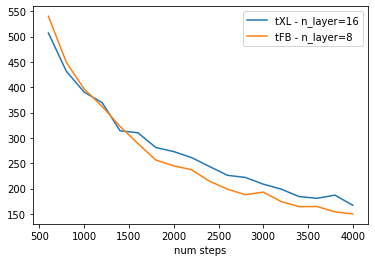

In [128]:
ax = xltransfo.plot('num steps', 'tXL - n_layer=16')
fbtransfo.plot('num steps', 'tFB - n_layer=8', ax=ax)